Pontificia Universidad Católica de Chile <br>
Departamento de Ciencia de la Computación <br>
IIC2433 - Minería de Datos
<br>

<center>
    <h2> Tarea 3 </h2>
    <h1> Regresión Logistica y GMM </h1>
    <p>
        Profesor Marcelo Mendoza<br>
        Primer Semestre 2023<br>    
        Fecha de entrega: Miércoles  26 de Abril
    </p>
    <br>
</center>

<br>

---

## Indicaciones

Deberás entregar **SOLO** el archivo .ipynb en el buzón respectivo en canvas. 

**IMPORTANTE**: 
- Se te dará puntaje tanto por código como por la manera en la que respondas las preguntas planteadas. Es decir, si tienes un código perfecto pero este no es explicado o no se responden preguntas asociadas a este, no se tendrá el puntaje completo.
- El notebook debe tener todas las celdas de código ejecutadas. Cualquier notebook que no las tenga no podrá ser corregido.
- El carácter de esta tarea es **INDIVIDUAL**. Cualquier instancia de copia resultará en un 1,1 como nota de curso.

---

## Librerías

In [94]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

## Utils

In [95]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Parte 1: Carga y Preprocesamiento de Datos
En esta tarea deberás trabajar con el dataset de Credit Card Fraud que puedes descargar de [Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).

### 1.1 Carga de Datos

In [96]:
dframe = pd.read_csv("creditcard.csv", encoding = "ISO-8859-1")

### 1.2 Descripción del dataset (2 pts.)
Investiga sobre el dataset y responder las siguientes preguntas:
- ¿En que consiste el dataset?
- ¿Que significan las variables?
- ¿Por que el dataset presenta las variables en la forma que lo hace?
- ¿Hay algo que te llame la atencion? (Hint: revisa la cantidad de datos por clase)

---
+ El dataset consiste en transacciones bancarias de tarjetas de credito en septiembre del 2013, este presenta transacciones ocurridas en dos dias, donde 492 de 284807 han sido fraudes.
+ Las columnas contienen la siguiente informacion:
    - **Time:** contiene los segundos transcurridos desde el inicio del dataset hacia la transaccion.
    - **V1, V2, ... , V28:** Es informacion protegida de los clientes representada en transformaciones PCA.
    - **Amount:** Es la cantidad de dinero de la transaccion.
    - **Class:** Es 1 si la transaccion es fraudulenta y 0 si no lo es.
+ Dado que la informacion del dataset es sensible, se ven en la obligacion de ocultar ciertos datos para darle privacidad a sus usuarios.
+ Todas las transformacion PCA me llaman la atencion, dado que no llego a entender porque serian 28 por transaccion. Lo otro que me llama la atencion es que la mayoria de transaccion fraudulentas son de 1 en la columna de amount
---

### 1.3 Preprocesamiento (2 pts.)
Una vez tengas claro en que consisten los datos debes prepararlos para ser usados. Realiza el preprocesamiento necesario, esto puede incluir remoción de valores nulos y outliers, normalización, entre otros. Es importante que cada paso sea justificado correctamente. 

In [97]:
dframe.dropna(inplace=True)
dframe[dframe.isnull().any(axis=1)].size
x_df = dframe.drop(['Time', 'Amount', 'Class'], axis=1)

vectorizer = DictVectorizer(sparse=False)
X = vectorizer.fit_transform(x_df.to_dict("records"))
X2 = vectorizer.fit_transform(x_df.to_dict("records"))

y = dframe.Class.values
classes = np.unique(y)

Primero elimine las filas con columnas vacias para eliminar datos poco significativos a la muestra, luego elimine la columna Time, Amount y Class para que se usar las columnas V's en la regresion logistica.
Para este dataset decidi no hacer una normalizacion minmax, dado que nos ofrecen datos PCA, que luego podran ser recuperados usando un reversePCA, cosa que no se podria hacer en caso de usar esta normalizacion.

#### 1.3.1 Train-test split (1 pt.)
Divide el dataset en conjuntos de training y de test. Usa el 70% de los datos para training y 30% para test.

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3)

## Parte 2: Regresión Logistica V1 (5 pts.)
Ahora que tienes los datos listos, entrena un clasificador de regresion logistica, evalua el modelo utilizando:
- Matriz de Confusión
- Accuracy
- Precision
- Recall

y comenta los resultados. Preguntas guia: 
- ¿Son estos resultados buenos?
- ¿El clasificador se comporta como queremos que lo haga?

In [99]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9991807403766253

In [100]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85298
           1       0.86      0.62      0.72       145

    accuracy                           1.00     85443
   macro avg       0.93      0.81      0.86     85443
weighted avg       1.00      1.00      1.00     85443



Normalized confusion matrix


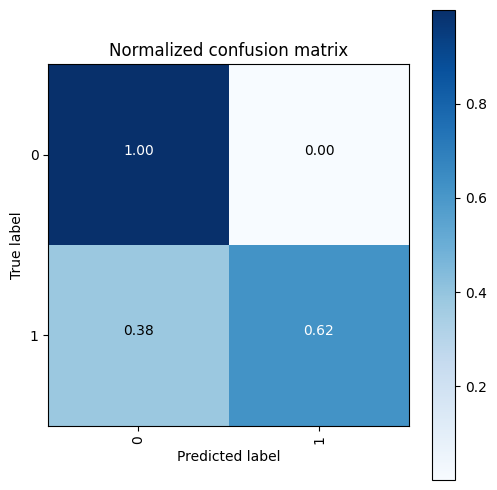

In [101]:
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='Normalized confusion matrix')

plt.show()

El clasificador dicta que para los casos que no son fraude, hay una precision del 100% de los casos. Por otro lado, los casos que si son fraude tenemos una precision del 69%.
Si bien se podrian considerar resultados "decentes", tenemos que analizar en que se esta usando esta informacion, donde una sola transaccion fraudulenta realizada puede afectar bastante al banco, por lo que un 31% de fallo es muy alto para la institucion.
El clasificador no se comporta como queremos, dado que el porcentaje real de fraudes en las transaccion es minimo, menor al 1%, por lo que la regresion logistica esta trabajando con una base de datos totalmente desbalanceada para generar sus conclusiones.

# Parte 3: GMM (10 pts.)
Es posible que en el caso anterior no hayas llegado a un tan buen resultado. Puede que la causa de eso sea el desbalance de clases en el dataset. Para arreglar el desbalance debes utilizar Gaussian Mixture Models. En esta parte tendras que:
- Ajustar una GMM de forma tal que permita arreglar el desbalance del dataset. Los parametros del modelo deben ser justificados.
- Generar datos desde la GMM e incorporarlos al dataset original.
- Para evaluar de forma cualitativa, debes usar PCA para reducir la dimensionalidad de los datos a 2 dimensiones, asi podras graficar los datos originales y los generados.
- Generar un nuevo set de datos de training y testing (70/30).

In [102]:
#Se importa nuevamente el dataframe para crear uno solo con los fraudes

dframeGMM = pd.read_csv("creditcard.csv", encoding = "ISO-8859-1")
dframeGMM.dropna(inplace=True)
df_frauds = dframeGMM[dframeGMM['Class'] == 1]

In [103]:
#Se dropean las columnas que no son necesarias para el GMM y se vectoriza el dataframe

x_frauds = df_frauds.drop(['Time', 'Amount', 'Class'], axis=1)
vectorizer = DictVectorizer(sparse=False)
X_frauds = vectorizer.fit_transform(x_frauds.to_dict("records"))

In [104]:
#Se busca el mejor numero de componentes para crear el modelo Gaussiando

n_components = np.arange(1, 30)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_frauds) for n in n_components]

aics = np.asarray([m.aic(X_frauds) for m in models])
components = np.where(aics == np.amin(aics))[0][0]

In [105]:
#Se crea el modelo GMM

gmm = GaussianMixture(n_components=components, covariance_type="full")
gmm.fit(X_frauds)
print(gmm.converged_)

True


In [106]:
# Se crean nuevos datos a partir del nuevo GMM

n_datos_nuevos = 5000

data_new = gmm.sample(n_datos_nuevos)
print(X_frauds)

[[-2.31 -2.77  3.2  ... -2.54  1.39 -2.77]
 [-3.04 -0.84 -0.41 ...  0.33 -0.07 -0.27]
 [-2.3  -1.53  2.03 ...  0.56 -0.4  -0.24]
 ...
 [-0.68 -3.46  1.79 ... -2.23  1.21 -0.65]
 [-3.11 -5.25  1.93 ... -2.21  1.06 -1.63]
 [ 1.99 -0.89  0.49 ...  0.22 -0.07  0.58]]


In [107]:
# Se creo un modelo de GMM a partir de los fraudes del dataset, para asi lograr crear una cantidad de estos que equilibren el desbalanceo del dataset.
X_gmm = np.concatenate((X, data_new[0]), axis=0)
y_gmm = np.concatenate((y, np.ones(n_datos_nuevos)))

In [108]:
# Se crea una reduccion de dimensionalidad con PCA para analizar los datos creados con los antiguos

pca = PCA(n_components=2) # n_components para reducir su dimensionalidad a dos
frauds_pca = pca.fit_transform(X_frauds)
new_frauds_pca = pca.fit_transform(data_new[0])

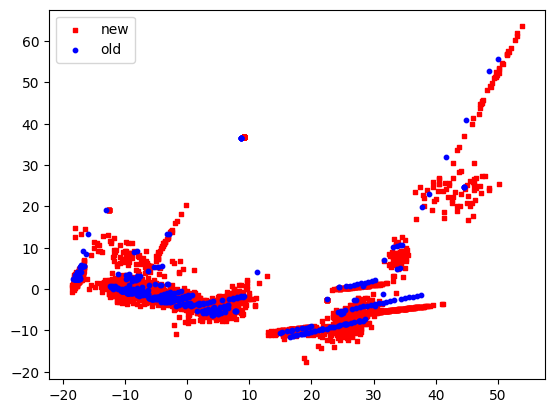

In [109]:
# Se plotean el PCA

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(new_frauds_pca[:, 0], new_frauds_pca[:, 1], s=10, c='r', marker="s", label='new')
ax1.scatter(frauds_pca[:, 0],frauds_pca[:, 1], s=10, c='b', marker="o", label='old')
plt.legend(loc='upper left')
plt.show()

#### Responde:
- ¿Por qué un desbalance de clases puede ser perjudicial para el clasificador?
- Analiza el grafico generado con PCA, ¿los datos generados se ven utiles?
---
- El desbalanceo es critico para crear un clasificador, ya que la regresion logistica tiene muy poca informacion para generar un resultado certero.
- Los datos generados por el GMM son muy parecidos en forma a los reales, por lo que perfectamente podrian ser usados para balancear el dataset si es necesario.


## Parte 4: Regresión Logistica V2 (10 pts.)
Finalmente debes entrenar denuevo el clasificador, pero esta vez utilizando el nuevo dataset con datos generados. Repite los mismos pasos que en la Parte 2, en esta parte debes obtener al menos un 85% de accuracy en ambas clases por separado. 

Responde:
- ¿Hubo mejoría en los resultados? Recuerda basarte en accuracy, precision y recall para justificar.
- Si no hubo cambios, identifica que paso o pasos desde el preprocesamiento hasta el entrenamiento de la parte 1 es/son los que hacen la diferencia entre un buen y un mal resultado. ¿Por que los pasos que lograste identificar son importantes?
- Si hubo cambios, mejora los pasos desde el preprocesamiento hasta el entrenamiento de la parte 1 para que obtengas resultados parecidos a la parte 4. ¿Por que estos pasos fueron importantes para mejorar el resultado de la parte 1?

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X_gmm, y_gmm, train_size=0.7, test_size=0.3)

In [111]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9965379616530371

In [112]:
# Classification report del X_test

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     85295
         1.0       0.97      0.84      0.90      1648

    accuracy                           1.00     86943
   macro avg       0.99      0.92      0.95     86943
weighted avg       1.00      1.00      1.00     86943



Normalized confusion matrix


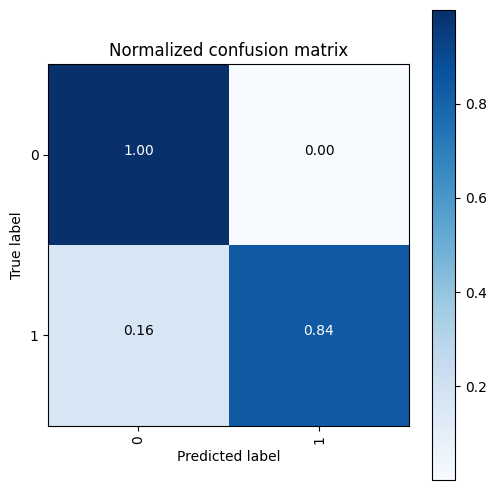

In [113]:
# Matriz de confusion del X_test


cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='Normalized confusion matrix')

plt.show()


In [114]:
# Classification report del X_train

y_pred_train = clf.predict(X_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    199020
         1.0       0.98      0.83      0.90      3844

    accuracy                           1.00    202864
   macro avg       0.99      0.92      0.95    202864
weighted avg       1.00      1.00      1.00    202864



Normalized confusion matrix


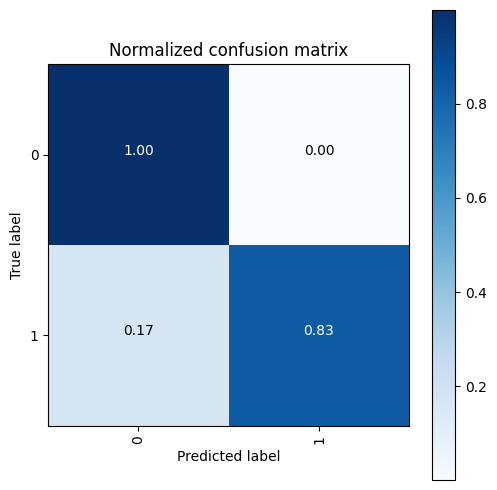

In [115]:
# Matriz de confusion del X_train

cnf_matrix = confusion_matrix(y_train, y_pred_train)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='Normalized confusion matrix')

plt.show()

- Si hubo cambios, mejora los pasos desde el preprocesamiento hasta el entrenamiento de la parte 1 para que obtengas resultados parecidos a la parte 4. ¿Por que estos pasos fueron importantes para mejorar el resultado de la parte 1?

- Hubo una clara mejoria en los resultados al implementar los datos del GMM, tanto como la precision y recall subieron, indicando que nuestra regresion es capaz de detectar mejor los casos positivos, falsos positivos y los negativos. 

- 